# Вступление

Многие люди изо всех сил пытаются получить кредиты из-за недостаточной или несуществующей кредитной истории. И, к сожалению, этим населением часто пользуются ненадежные кредиторы.

Home Credit стремится расширить доступ к финансовым услугам для населения, не охваченного банковскими услугами, путем предоставления положительного и безопасного опыта заимствования. Чтобы удостовериться, что у этого недостаточно обслуживаемого населения есть положительный опыт кредитования, Home Credit использует различные альтернативные данные, включая информацию о телефонных компаниях и транзакциях, для прогнозирования платежеспособности своих клиентов.

Хотя, Home Credit в настоящее время использует различные статистические методы и методы машинного обучения, чтобы делать эти прогнозы, они бросают вызов Kagglers, чтобы помочь им полностью раскрыть потенциал своих данных. Это гарантирует, что клиенты, способные к погашению, не будут отвергнуты и что ссуды будут предоставлены с указанием основной суммы, срока погашения и календаря погашения, что позволит их клиентам добиться успеха.

**Задача**:
    
    - Следует предсказать, сможет ли человек с недостаточночной кредитной историей или вообще с отсутствующей,  быть благонадежным заемщиком, который не будет допускать просрочку платежей и в итоге вернет кредит банку
    
    - На основе данных мы должны выявить признаки, характерные для плохих заемщиков, которые допускают просрочку по кредиту. Для этого у нас есть целевая переменная.
    
    - Целевая переменная - TARGET. (1 - клиент с трудностями при оплате: он / она просрочил платеж более чем на X дней по крайней мере по одному из первых Y взносов кредита в нашей выборке, 0 - во всех остальных случаях)

<img src="https://is4-ssl.mzstatic.com/image/thumb/Purple114/v4/c3/3d/85/c33d8584-dd12-c7e5-625c-cce46563fd77/source/512x512bb.jpg" width="200">

# Импорт данных/библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, accuracy_score, \
precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

import warnings
warnings.filterwarnings("ignore")

import shap

# Фиксируем random-state
RAND=10

In [2]:
appl_test = pd.read_csv('../Pet-Project/application_test.csv')

appl_train = pd.read_csv('../Pet-Project/application_train.csv')

# Первый взгляд на данные

In [3]:
# отобразим все столбцы в таблице

pd.set_option('display.max_columns', None)

In [4]:
appl_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
appl_train.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [6]:
print(f'Test size is {appl_test.shape}')
print(f'Train size is {appl_train.shape}')

Test size is (48744, 121)
Train size is (307511, 122)


In [7]:
appl_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [8]:
appl_train.drop(['SK_ID_CURR', 'TARGET'], axis=1).describe(include='int64')

,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
appl_train.describe(include='O')

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


# Посмотрим на пропуски

In [10]:
percent = (appl_train.isnull().sum() / appl_train.isnull().count()
           * 100).sort_values(ascending=False)

df = pd.DataFrame({'percent': percent})
df.head(25)

,percent
COMMONAREA_MEDI,69.872297
COMMONAREA_AVG,69.872297
COMMONAREA_MODE,69.872297
NONLIVINGAPARTMENTS_MODE,69.432963
NONLIVINGAPARTMENTS_AVG,69.432963
NONLIVINGAPARTMENTS_MEDI,69.432963
FONDKAPREMONT_MODE,68.386172
LIVINGAPARTMENTS_MODE,68.354953
LIVINGAPARTMENTS_AVG,68.354953
LIVINGAPARTMENTS_MEDI,68.354953


# Data Exploration

Гипотезы:
- 1) Большинство людей, кто допускает просрочку, работают на низкой должности. 
- 2) Если человек живет в городе с низким рейтингом (маленький город, низкий уровень жизни и т.д), риск просрочки платежа увеличивается
- 3) Клиент со средним образованием будет чаще допускать просрочку, нежели клиент с высшим образованием

## Распределение таргета

In [11]:
target = appl_train['TARGET'].value_counts()
df = pd.DataFrame({'labels': target.index,
                   'values': target.values
                  })

df.iplot(kind='pie', labels='labels', values='values', title='Распределение таргета')

Видим довольно сильный дисбаланс классов

## Возраст клиента

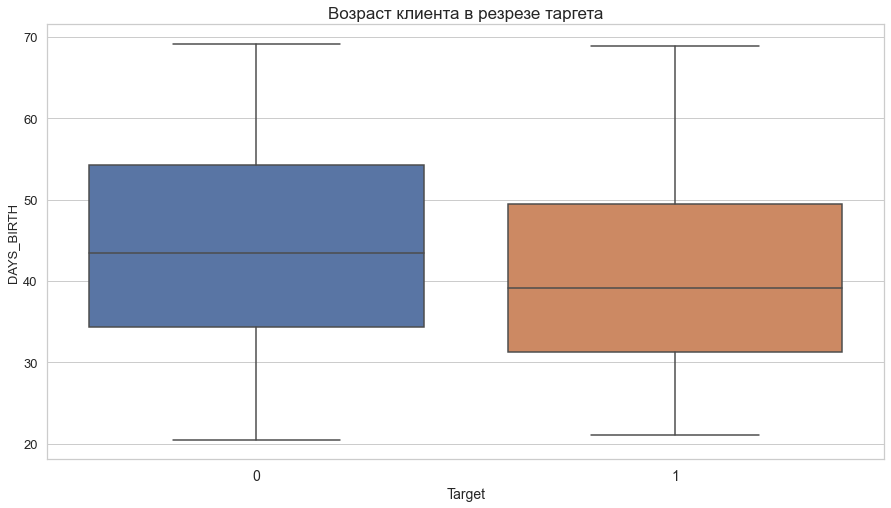

In [12]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.boxplot(data=appl_train, y=(abs(appl_train['DAYS_BIRTH']) / 365), x='TARGET')

plt.xlabel('Target', fontsize=14)
plt.ylabel('DAYS_BIRTH', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.title('Возраст клиента в резрезе таргета', fontsize=17)

plt.show()

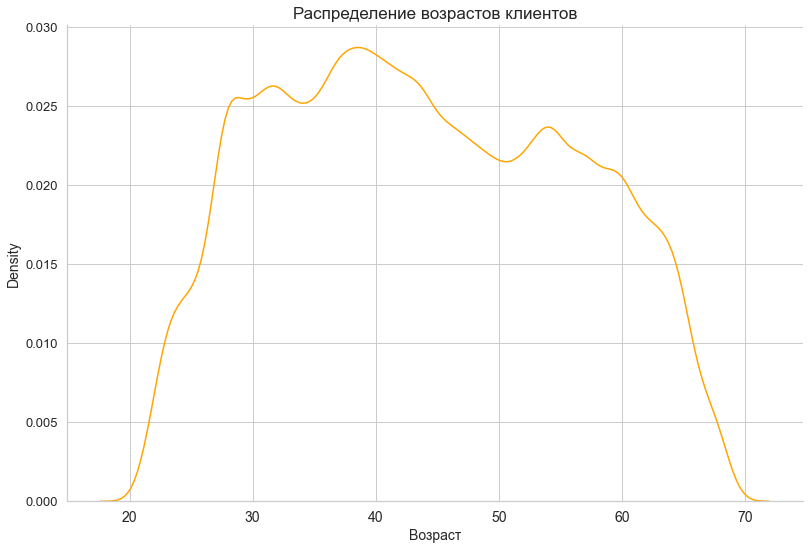

In [13]:
sns.set_theme(style="whitegrid")
displot = sns.displot(x=(abs(appl_train.DAYS_BIRTH) / 365), kind='kde', color='orange')

displot.fig.set_figheight(8)
displot.fig.set_figwidth(13)

plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Распределение возрастов клиентов', fontsize=17)

plt.show()

Интерквартильный размах 34-54 года, средний возраст около 43 лет. Можно заметить, что просрочка по кредиту свойственна более молодым заемщикам, средний возраст меньше 40 лет.

## Типы выдаваемых кредитов

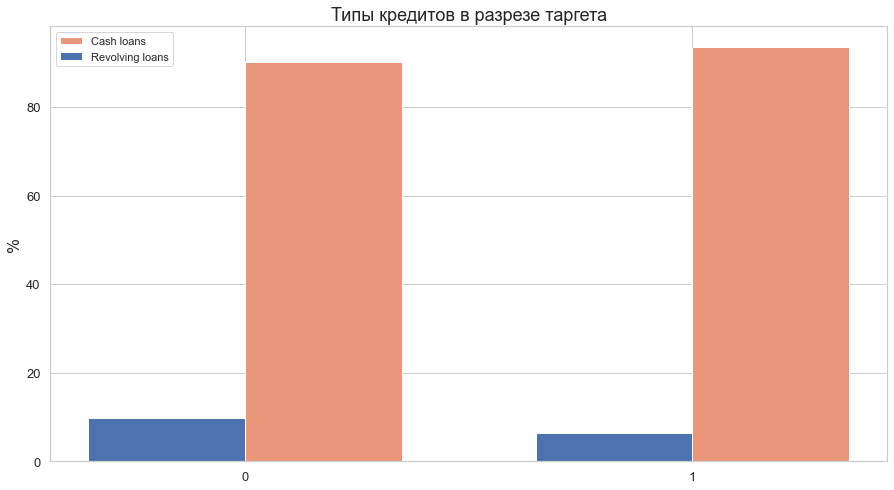

In [14]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_CONTRACT_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_CONTRACT_TYPE'].count()
norma = (target_group / all_count) * 100

# Строим график по нормированным данным

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(norma[0].index))
width = 0.35

ax.bar(x=x + width/2, height=(norma[0][0], norma[1][0]), width=0.35, label='Cash loans', color='darksalmon')
ax.bar(x=x - width/2, height=(norma[0][1], norma[1][1]), width=0.35, label='Revolving loans')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_ylabel('%', fontsize=17)
ax.set_title('Типы кредитов в разрезе таргета', fontsize=18)
ax.set_xticks(x)
ax.legend();

Большую часть кредитов банк выдает частным лицам

## Наличие имущества у заемщика

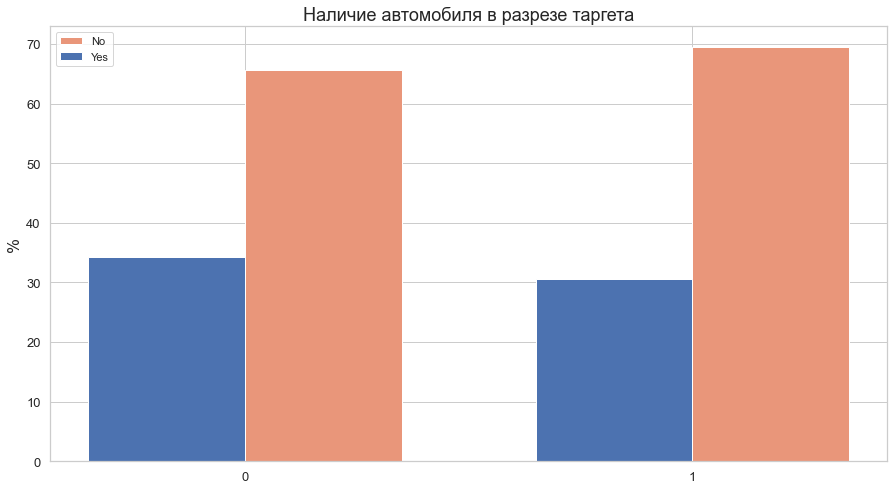

In [15]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'FLAG_OWN_CAR'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['FLAG_OWN_CAR'].count()
norma = (target_group / all_count) * 100

# Строим график по нормированным данным

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(norma[0].index))
width = 0.35

ax.bar(x=x + width/2, height=(norma[0][0], norma[1][0]), width=0.35, label='No', color='darksalmon')
ax.bar(x=x - width/2, height=(norma[0][1], norma[1][1]), width=0.35, label='Yes')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_ylabel('%', fontsize=17)
ax.set_title('Наличие автомобиля в разрезе таргета', fontsize=18)
ax.set_xticks(x)
ax.legend();

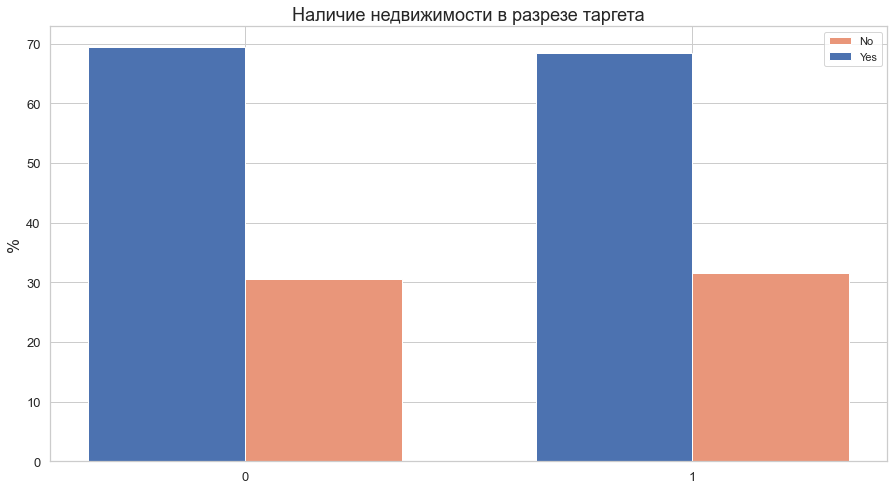

In [16]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'FLAG_OWN_REALTY'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['FLAG_OWN_REALTY'].count()
norma = (target_group / all_count) * 100

# Строим график по нормированным данным

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(norma[0].index))
width = 0.35

ax.bar(x=x + width/2, height=(norma[0][0], norma[1][0]), width=0.35, label='No', color='darksalmon')
ax.bar(x=x - width/2, height=(norma[0][1], norma[1][1]), width=0.35, label='Yes')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_ylabel('%', fontsize=17)
ax.set_title('Наличие недвижимости в разрезе таргета', fontsize=18)
ax.set_xticks(x)
ax.legend();

Преимущественно у людей есть недвижимость, но нет собственной машины

## Виды доходов заемщиков

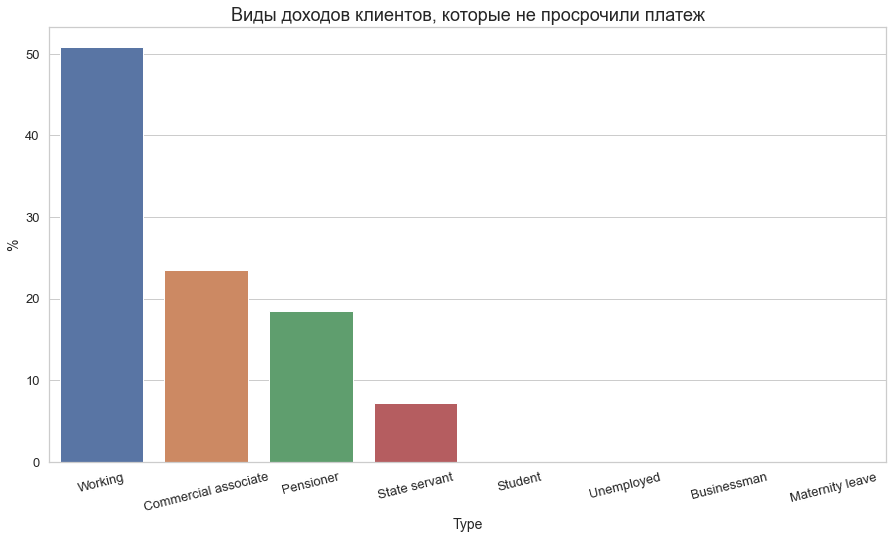

In [17]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_INCOME_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_INCOME_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(x=norma[0].index, y=norma[0].sort_values(ascending=False))

plt.xlabel('Type', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.xticks(fontsize=13, rotation=14)
plt.yticks(fontsize=13)
plt.title('Виды доходов клиентов, которые не просрочили платеж', fontsize=18)

plt.show()

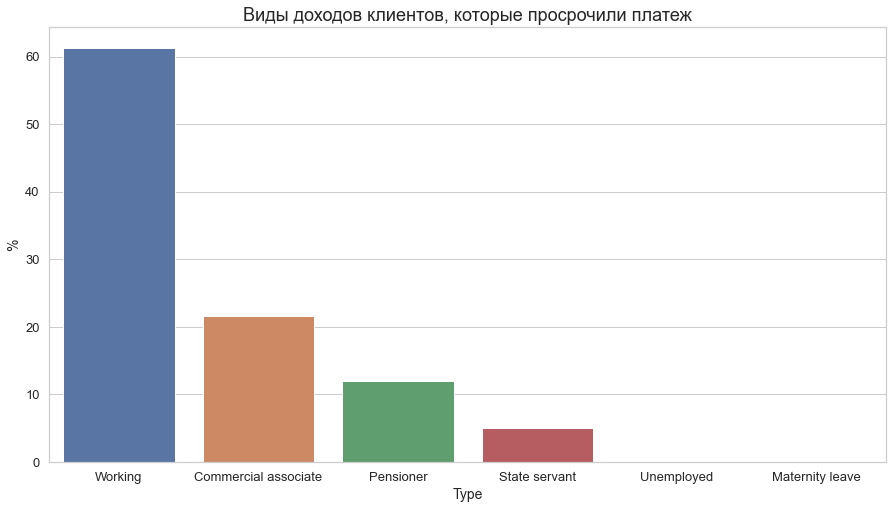

In [18]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_INCOME_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_INCOME_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(x=norma[1].index, y=norma[1].sort_values(ascending=False))

plt.xlabel('Type', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Виды доходов клиентов, которые просрочили платеж', fontsize=18)

plt.show()

Профессия обычного рабочего преобладает как и в просрочке платежа, так и при его возврате в срок

### Статус кредита в разрезе должности клиента

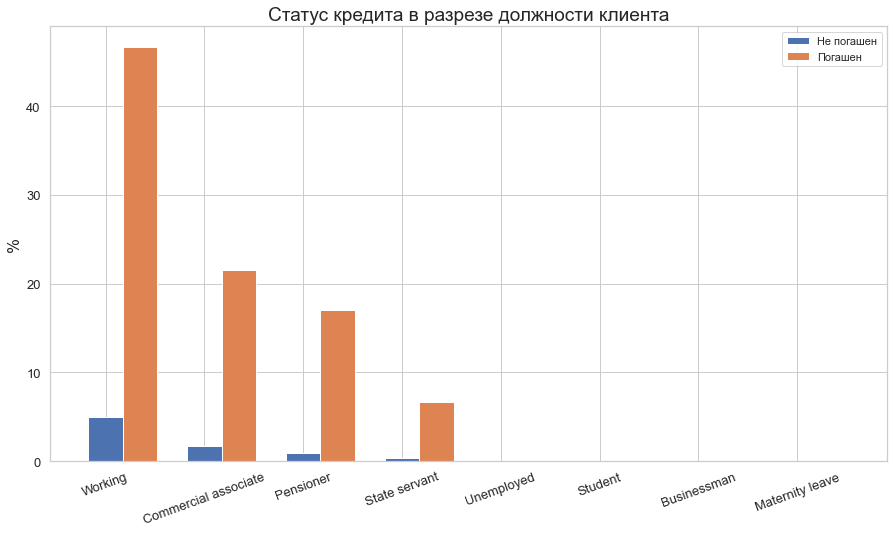

In [19]:
temp = appl_train["NAME_INCOME_TYPE"].value_counts()

temp_y0 = []
temp_y1 = []

for val in temp.index:
    temp_y1.append(np.sum(appl_train["TARGET"][appl_train["NAME_INCOME_TYPE"] == val] == 1))
    temp_y0.append(np.sum(appl_train["TARGET"][appl_train["NAME_INCOME_TYPE"] == val] == 0)) 

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(temp.index))
width = 0.35

ax.bar(x = temp.index, height = (temp_y1 / temp.sum()) * 100, width=0.35, label='Не погашен')
ax.bar(x = x + width, height = (temp_y0 / temp.sum()) * 100, width=0.35, label='Погашен')
plt.xticks(fontsize=13, rotation=20)
plt.yticks(fontsize=13)
plt.ylabel('%', fontsize=17)
plt.title('Статус кредита в разрезе должности клиента', fontsize=19)
plt.legend()

plt.show()

Распределение клиентов в разрезе задержки платежа / выплаты в срок - равномерное

## Семейное положение клиентов

### Семейное положение клиентов, которые просрочили / не просрочили платеж

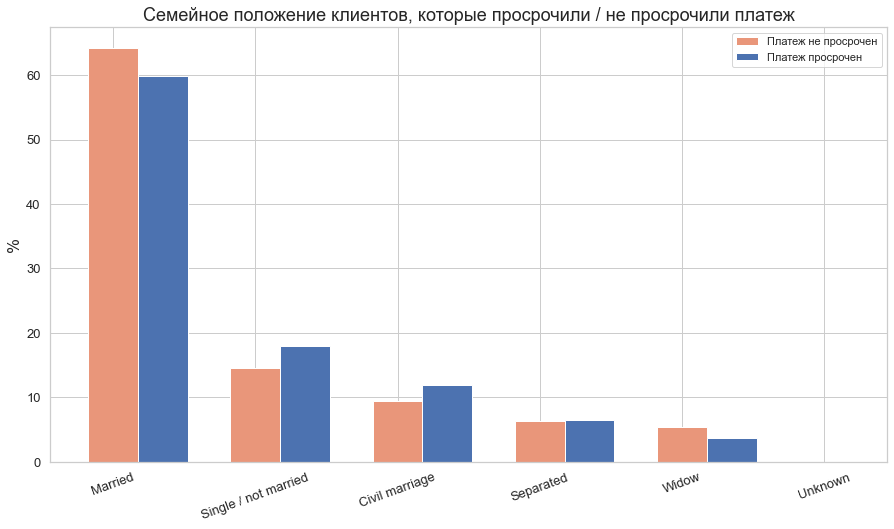

In [20]:
# Нормируем данные на размер класса

target_group = appl_train.groupby(['TARGET', 'NAME_FAMILY_STATUS'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_FAMILY_STATUS'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(norma[1].index))
width = 0.35

ax.bar(x=norma[0].index, height=(norma[0]), width=0.35, label='Платеж не просрочен', color='darksalmon')
ax.bar(x=x + width, height=norma[1], width=0.35, label='Платеж просрочен')

plt.xticks(fontsize=13, rotation=20)
plt.yticks(fontsize=13)
ax.set_ylabel('%', fontsize=17)
ax.set_title('Семейное положение клиентов, которые просрочили / не просрочили платеж', fontsize=18)
ax.legend();

Самое популярное семейное положение - замужем/женат

### Статус кредита в разрезе семейного положения

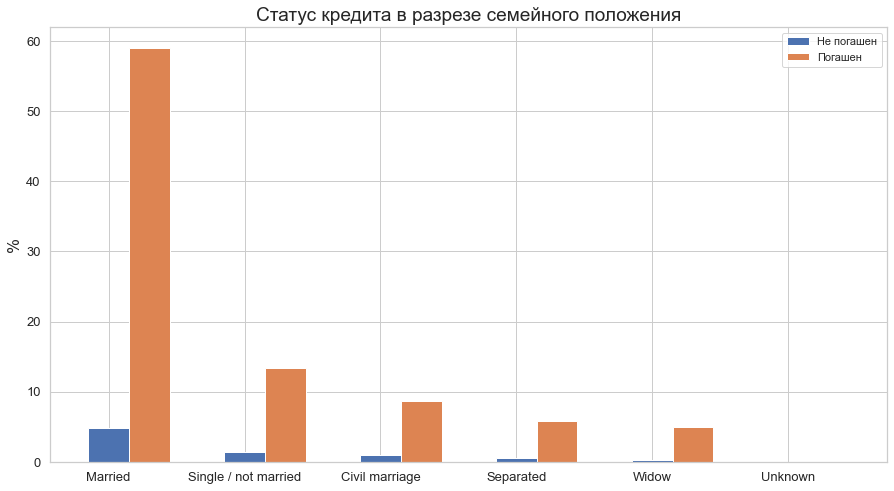

In [21]:
temp = appl_train["NAME_FAMILY_STATUS"].value_counts()

temp_y0 = []
temp_y1 = []

for val in temp.index:
    temp_y1.append(np.sum(appl_train["TARGET"][appl_train["NAME_FAMILY_STATUS"] == val] == 1))
    temp_y0.append(np.sum(appl_train["TARGET"][appl_train["NAME_FAMILY_STATUS"] == val] == 0)) 

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(temp.index))
width = 0.3

ax.bar(x = temp.index, height = (temp_y1 / temp.sum()) * 100, width=0.3, label='Не погашен')
ax.bar(x = x + width, height = (temp_y0 / temp.sum()) * 100, width=0.3, label='Погашен')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('%', fontsize=17)
plt.title('Статус кредита в разрезе семейного положения', fontsize=19)
plt.legend()

plt.show()

Распределение клиентов в разрезе задержки платежа / выплаты в срок - равномерное

## Сферы деятельности заемщиков

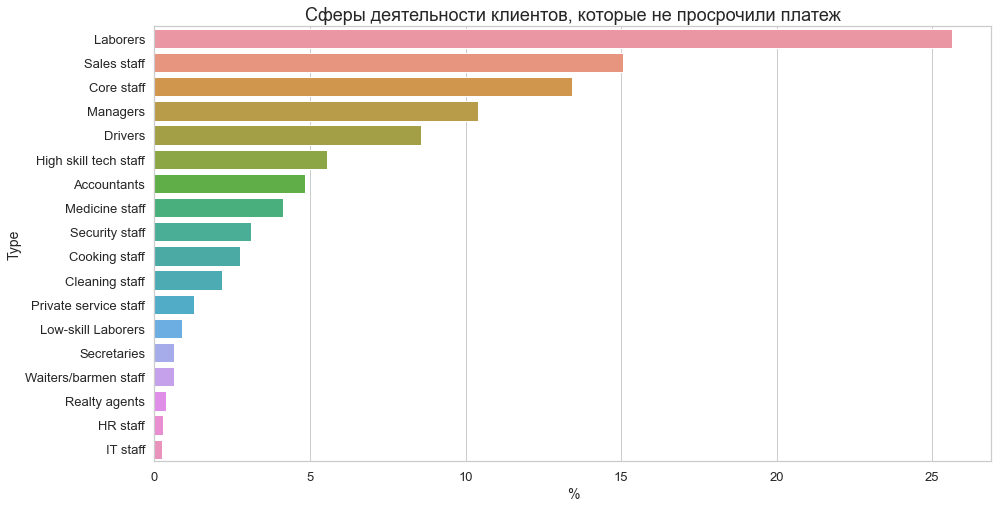

In [22]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'OCCUPATION_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['OCCUPATION_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[0].index, x=norma[0].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Сферы деятельности клиентов, которые не просрочили платеж', fontsize=18)

plt.show()

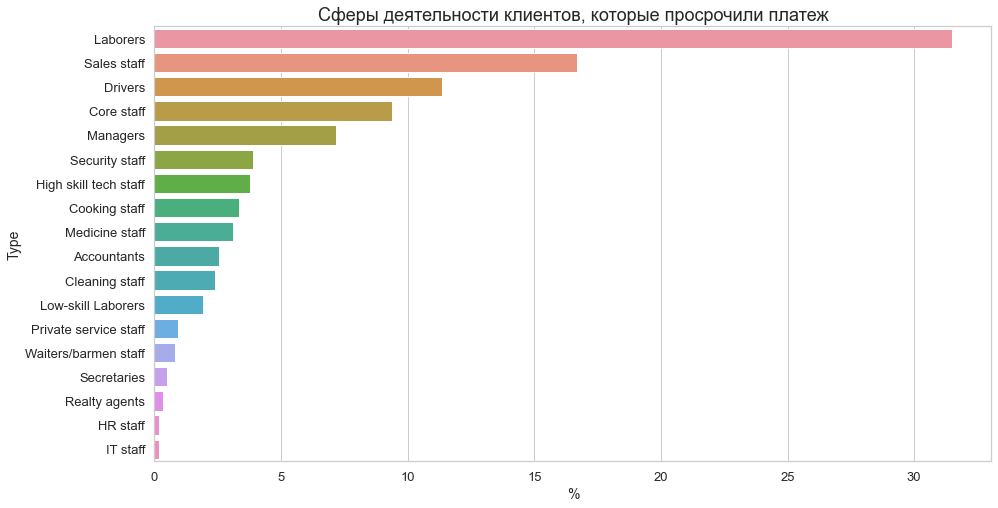

In [23]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'OCCUPATION_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['OCCUPATION_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[1].index, x=norma[1].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Сферы деятельности клиентов, которые просрочили платеж', fontsize=18)

plt.show()

Сильно выделяется группа неквалифицированных рабочих. Далее идут продавцы, менеджеры, основной персонал и тд

### Статус кредита в разрезе сферы деятельности

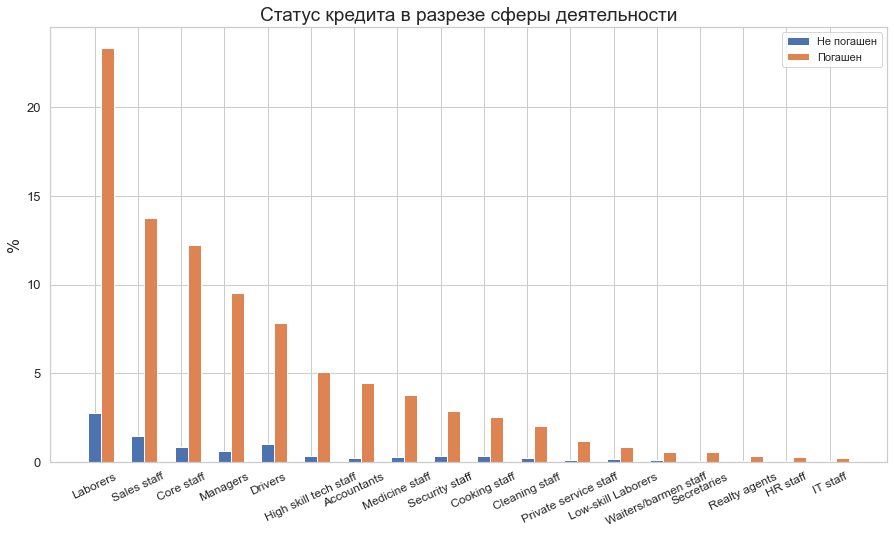

In [24]:
temp = appl_train['OCCUPATION_TYPE'].value_counts()

temp_y0 = []
temp_y1 = []

for val in temp.index:
    temp_y1.append(np.sum(appl_train["TARGET"][appl_train["OCCUPATION_TYPE"] == val] == 1))
    temp_y0.append(np.sum(appl_train["TARGET"][appl_train["OCCUPATION_TYPE"] == val] == 0)) 

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(temp.index))
width = 0.3

ax.bar(x = temp.index, height = (temp_y1 / temp.sum()) * 100, width=0.3, label='Не погашен')
ax.bar(x = x + width, height = (temp_y0 / temp.sum()) * 100, width=0.3, label='Погашен')
plt.xticks(fontsize=12, rotation=25)
plt.yticks(fontsize=13)
plt.ylabel('%', fontsize=17)
plt.title('Статус кредита в разрезе сферы деятельности', fontsize=19)
plt.legend()

plt.show()

Распределение клиентов в разрезе задержки платежа / выплаты в срок - равномерное

## Наличие образования

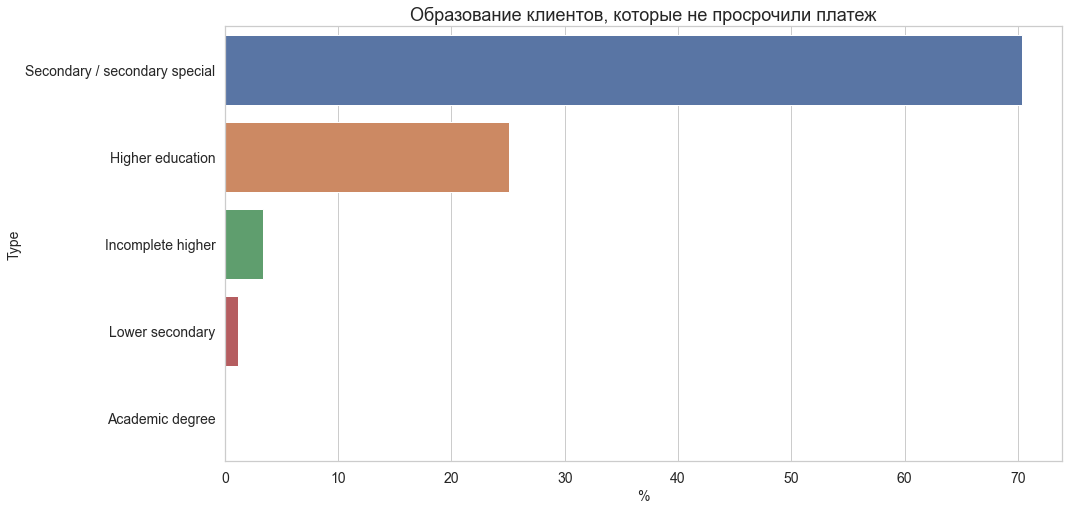

In [25]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_EDUCATION_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_EDUCATION_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[0].index, x=norma[0].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Образование клиентов, которые не просрочили платеж', fontsize=18)

plt.show()

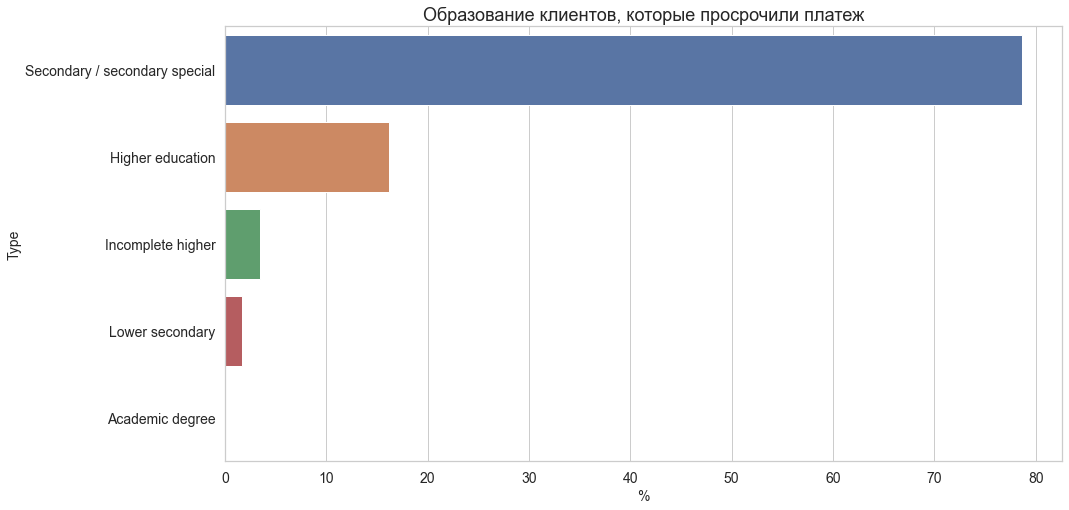

In [26]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_EDUCATION_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_EDUCATION_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[1].index, x=norma[1].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Образование клиентов, которые просрочили платеж', fontsize=18)

plt.show()

Исходя из предыдущего графика, можно подтвердить гипотезу о том, что основными клиентами банка являются мало квалифицированные рабочие со средним образованием. Но также можно отметить заметную долю клиентов (~16%) с высшим образванием

### Статус кредита в разрезе образования

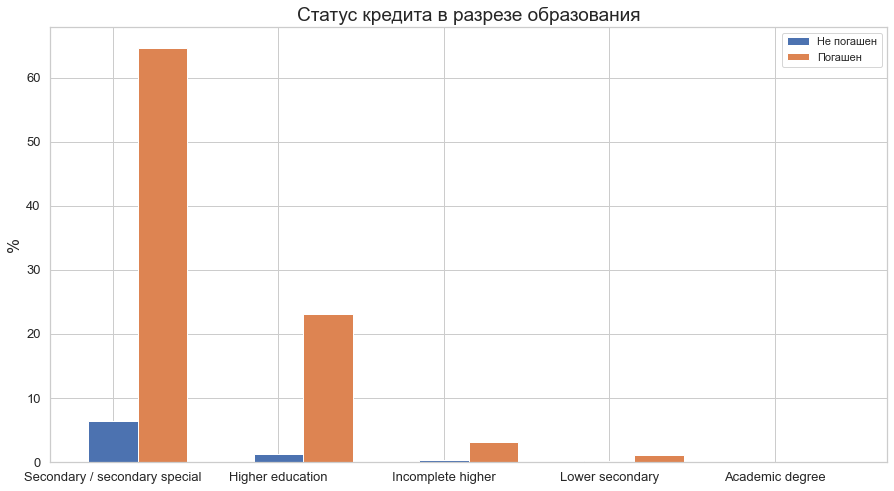

In [27]:
temp = appl_train['NAME_EDUCATION_TYPE'].value_counts()

temp_y0 = []
temp_y1 = []

for val in temp.index:
    temp_y1.append(np.sum(appl_train["TARGET"][appl_train["NAME_EDUCATION_TYPE"] == val] == 1))
    temp_y0.append(np.sum(appl_train["TARGET"][appl_train["NAME_EDUCATION_TYPE"] == val] == 0)) 

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(temp.index))
width = 0.3

ax.bar(x = temp.index, height = (temp_y1 / temp.sum()) * 100, width=0.3, label='Не погашен')
ax.bar(x = x + width, height = (temp_y0 / temp.sum()) * 100, width=0.3, label='Погашен')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('%', fontsize=17)
plt.title('Статус кредита в разрезе образования', fontsize=19)
plt.legend()

plt.show()

Распределение клиентов в разрезе задержки платежа / выплаты в срок - равномерное

## Тип дома в котором проживает клиент

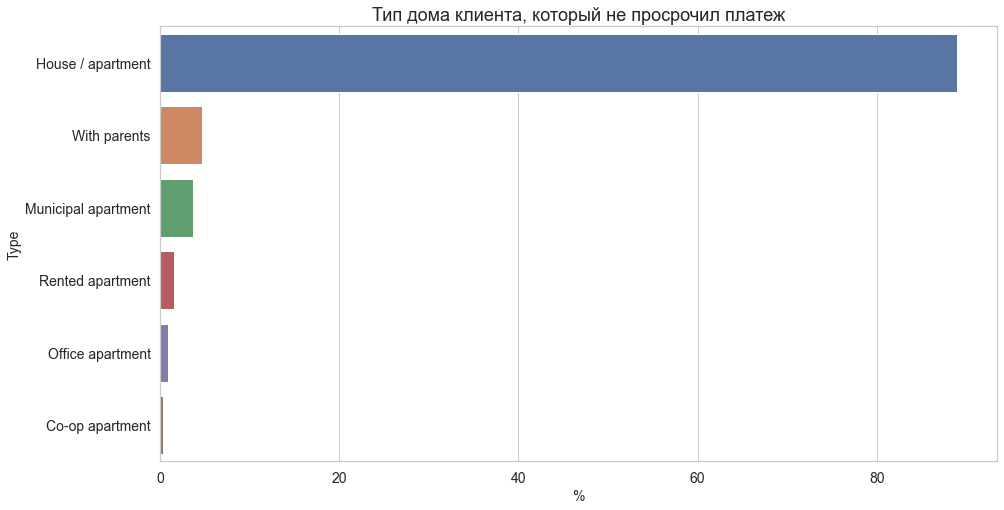

In [28]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_HOUSING_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_HOUSING_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[0].index, x=norma[0].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Тип дома клиента, который не просрочил платеж', fontsize=18)

plt.show()

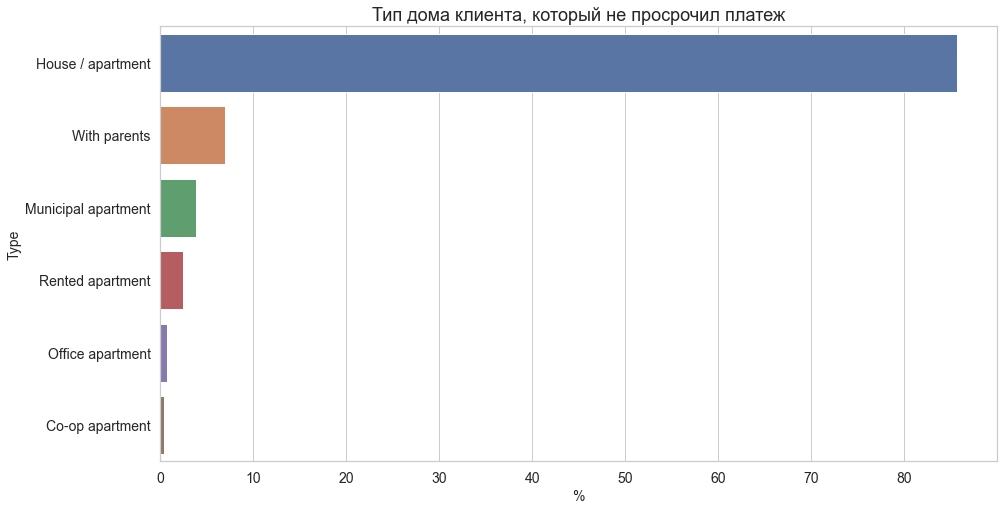

In [29]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_HOUSING_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_HOUSING_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[1].index, x=norma[1].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Тип дома клиента, который не просрочил платеж', fontsize=18)

plt.show()

Почти все заемщики проживают в доме/апартаментах

### Статус кредита в разрезе места проживания заемщика

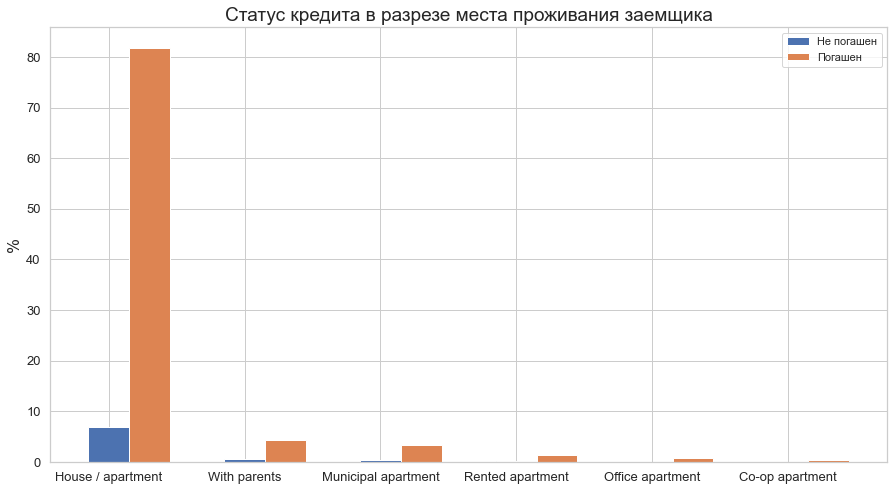

In [30]:
temp = appl_train['NAME_HOUSING_TYPE'].value_counts()

temp_y0 = []
temp_y1 = []

for val in temp.index:
    temp_y1.append(np.sum(appl_train["TARGET"][appl_train["NAME_HOUSING_TYPE"] == val] == 1))
    temp_y0.append(np.sum(appl_train["TARGET"][appl_train["NAME_HOUSING_TYPE"] == val] == 0)) 

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(temp.index))
width = 0.3

ax.bar(x = temp.index, height = (temp_y1 / temp.sum()) * 100, width=0.3, label='Не погашен')
ax.bar(x = x + width, height = (temp_y0 / temp.sum()) * 100, width=0.3, label='Погашен')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('%', fontsize=17)
plt.title('Статус кредита в разрезе места проживания заемщика', fontsize=19)
plt.legend()

plt.show()

Распределение клиентов в разрезе задержки платежа / выплаты в срок - равномерное

# Feature Engineering

In [31]:
# Создаем набор новых фичей на train

# Процент отработанных дней в разрезе возраста клиента
appl_train['DAYS_EMPLOYED_PERCENT'] = appl_train['DAYS_EMPLOYED'] / \
    appl_train['DAYS_BIRTH']

# Процент суммы кредита в разрезе дохода клиента
appl_train['CREDIT_INCOME_PERCENT'] = appl_train['AMT_CREDIT'] / \
    appl_train['AMT_INCOME_TOTAL']

# Продолжительность платежа в месяцах
appl_train['CREDIT_TERM'] = appl_train['AMT_ANNUITY'] / \
    appl_train['AMT_CREDIT']

# Возраст клиента в кол-ве лет
appl_train['DAYS_BIRTH'] = abs(appl_train['DAYS_BIRTH'] / 365)

# Кредитные коэффициенты
appl_train['CREDIT_TO_ANNUITY_RATIO'] = appl_train['AMT_CREDIT'] / \
    appl_train['AMT_ANNUITY']
appl_train['CREDIT_TO_GOODS_RATIO'] = appl_train['AMT_CREDIT'] / \
    appl_train['AMT_GOODS_PRICE']

# Коэффициенты доходов
appl_train['ANNUITY_TO_INCOME_RATIO'] = appl_train['AMT_ANNUITY'] / \
    appl_train['AMT_INCOME_TOTAL']
appl_train['CREDIT_TO_INCOME_RATIO'] = appl_train['AMT_CREDIT'] / \
    appl_train['AMT_INCOME_TOTAL']
appl_train['INCOME_TO_BIRTH_RATIO'] = appl_train['AMT_INCOME_TOTAL'] / \
    appl_train['DAYS_BIRTH']

In [32]:
# Создаем новые фичи в тестовых данных

appl_test['DAYS_EMPLOYED_PERCENT'] = appl_test['DAYS_EMPLOYED'] / \
    appl_test['DAYS_BIRTH']

appl_test['CREDIT_INCOME_PERCENT'] = appl_test['AMT_CREDIT'] / \
    appl_test['AMT_INCOME_TOTAL']

appl_test['CREDIT_TERM'] = appl_test['AMT_ANNUITY'] / \
    appl_test['AMT_CREDIT']

appl_test['DAYS_BIRTH'] = abs(appl_test['DAYS_BIRTH'] / 365)

appl_test['CREDIT_TO_ANNUITY_RATIO'] = appl_test['AMT_CREDIT'] / \
    appl_test['AMT_ANNUITY']
appl_test['CREDIT_TO_GOODS_RATIO'] = appl_test['AMT_CREDIT'] / \
    appl_test['AMT_GOODS_PRICE']

appl_test['ANNUITY_TO_INCOME_RATIO'] = appl_test['AMT_ANNUITY'] / \
    appl_test['AMT_INCOME_TOTAL']
appl_test['CREDIT_TO_INCOME_RATIO'] = appl_test['AMT_CREDIT'] / \
    appl_test['AMT_INCOME_TOTAL']
appl_test['INCOME_TO_BIRTH_RATIO'] = appl_test['AMT_INCOME_TOTAL'] / \
    appl_test['DAYS_BIRTH']

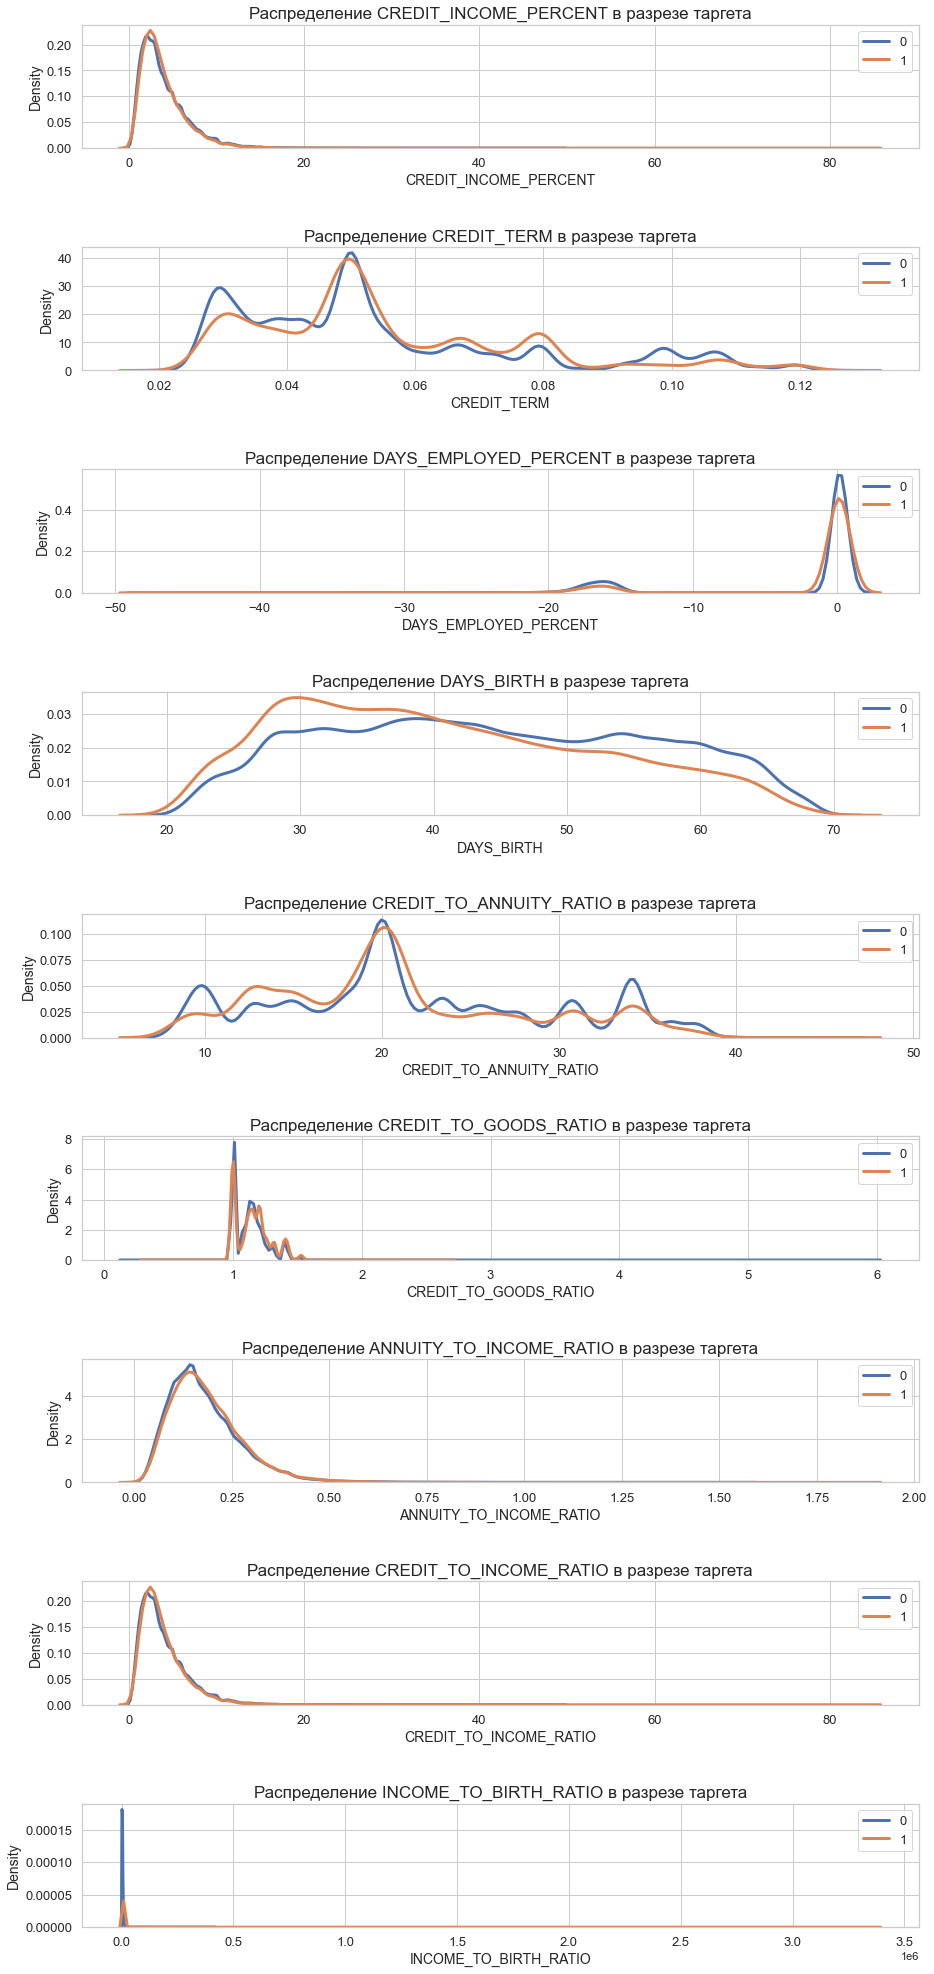

In [33]:
plt.figure(figsize=(15, 35))

# Создадим цикл for для построения графиков наших новых фичей
for num, feature in enumerate(['CREDIT_INCOME_PERCENT', 'CREDIT_TERM', 
                               'DAYS_EMPLOYED_PERCENT', 'DAYS_BIRTH', 
                               'CREDIT_TO_ANNUITY_RATIO', 'CREDIT_TO_GOODS_RATIO',
                               'ANNUITY_TO_INCOME_RATIO', 'CREDIT_TO_INCOME_RATIO',
                               'INCOME_TO_BIRTH_RATIO']):
    
    # Зададим стиль и subplot
    plt.subplot(9, 1, num + 1)
    plt.subplots_adjust(wspace=0.8, hspace=0.8)
    sns.set_theme(style="whitegrid")
    
    # Feature в разрезе таргета = 0
    sns.kdeplot(appl_train.loc[appl_train['TARGET'] == 0, feature], label='0', linewidth=3)
    
    # Feature в разрезе таргета = 1
    sns.kdeplot(appl_train.loc[appl_train['TARGET'] == 1, feature], label='1', linewidth=3)
    
    # Обозначения графиков
    plt.title('Распределение %s в разрезе таргета' % feature, fontsize=17)
    plt.xlabel('%s' % feature, fontsize=14) 
    plt.ylabel('Density', fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(fontsize=13)

# Baseline

In [34]:
# Заполняем пропуски в данных

def func_fill(data):
    if isinstance(data, pd.Series):
        try:
            if data.dtype is pd.np.dtype(float):
                data.fillna(data.median(), inplace=True)
            elif data.dtype is pd.np.dtype(int):
                data.fillna(data.median(), inplace=True)
            elif data.dtype is pd.np.dtype(object):
                data.fillna(data.mode()[0], inplace=True)
            else:
                ('Не нашел указанные типы')
        except Exception as ex:
            print(f'Поздравляю, у тебя ошибка - {ex}')
    else:
        print('Series, не DF -_-')

In [35]:
for col in appl_train.columns:
    func_fill(appl_train[col])
    
for col in appl_test.columns:
    func_fill(appl_test[col])

In [36]:
# DataFrame для записи результатов

metrics = pd.DataFrame(
    index=('ROC-AUC', 'F1', 'Accuracy', 'Precision', 'Recall'))

## Проверка данных на выбросы

In [37]:
# Попробуем найти выбросы

# Бинаризуем полный сет данных
lx_cols = appl_train.dtypes[appl_train.dtypes == 'O'].index.to_list()
lx_train = pd.get_dummies(data=appl_train, columns=lx_cols)

# Разбиваем на train и test
X = lx_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = lx_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [38]:
# Обучаем модель

lg = LogisticRegression(class_weight='balanced')

lg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [39]:
y_proba = lg.predict_proba(X_test)

In [40]:
# Создаем датасеты с данными и выводим

df_test = pd.DataFrame(y_test)
df_proba = pd.DataFrame(y_proba[:, 1:])
df = pd.merge(df_test['TARGET'], df_proba, left_index=True, right_index=True)
df = df.rename(columns = {0: 'probability'})

df.sort_values(by='probability', ascending=False).head(25)

,TARGET,probability
4542,0,0.953897
29684,0,0.937538
26454,0,0.927828
5629,0,0.812600
26876,0,0.794748
51490,0,0.782595
51359,0,0.780005
2520,1,0.776264
14182,0,0.772266
42793,0,0.770768


При вероятности > 0.85 довольно много id с таргетом 0 (вернут кредит). Для лучшего распознавания зависимотей моделью,
запишем их в переменную wrong_indexes_train, для того чтобы удалить и сравнить скоры с исходными данными

In [41]:
# Копируем исходный датасет

outlayers_df = appl_train.copy()

In [42]:
# Записываем наши выбросы в переменную

wrong_indexes_train = df[(df['probability'] > 0.85) & (df['TARGET'] == 0)].index

## Logistic Regression

In [43]:
# Бинаризуем наши данные

lx_cols = appl_train.dtypes[appl_train.dtypes == 'O'].index.to_list()

lx_train = pd.get_dummies(data=appl_train, columns=lx_cols)

In [44]:
# Разбиваем данные на train и test

X = lx_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = lx_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [45]:
# Обучаем модель

lg = LogisticRegression(class_weight='balanced')

lg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [46]:
# Предиктим и смотрим на метрики

y_proba = lg.predict_proba(X_test)
y_pred = lg.predict(X_test)

metrics['LogisticRegression'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                                  f1_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  precision_score(y_test, y_pred),
                                  recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.6202324260912024
F1 = 0.19216928170433278
Accuracy = 0.6350096743248297
Precision = 0.11698724970424572
Recall = 0.5377643504531722


In [47]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(lg, X, y, scoring='roc_auc', cv=folds)

print(f"ShuffleSplit = {np.abs(scores)}")

ShuffleSplit = [0.61601793 0.61277729 0.61187772]


Теперь пробуем удалить выбросы и посмотреть на скор

In [48]:
outlayers_df = outlayers_df.drop(wrong_indexes_train, axis=0)

In [49]:
# Бинаризуем наши данные

lx_cols = outlayers_df.dtypes[outlayers_df.dtypes == 'O'].index.to_list()

lx_train = pd.get_dummies(data=outlayers_df, columns=lx_cols)

In [50]:
# Разбиваем данные на train и test

X = lx_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = lx_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [51]:
# Обучаем модель

lg = LogisticRegression(class_weight='balanced')

lg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [52]:
# Предиктим и смотрим на метрики

y_proba = lg.predict_proba(X_test)
y_pred = lg.predict(X_test)

metrics['LogisticRegression'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                                  f1_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  precision_score(y_test, y_pred),
                                  recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.6196545209964275
F1 = 0.1923209723085422
Accuracy = 0.6196546453773861
Precision = 0.11605617368837771
Recall = 0.5609264853977844


In [53]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(lg, X, y, scoring='roc_auc', cv=folds)

print(f"ShuffleSplit = {np.abs(scores)}")

ShuffleSplit = [0.61276415 0.61878761 0.61361281]


## XGBClassifier

In [54]:
# Бинаризуем наши данные

lx_cols = appl_train.dtypes[appl_train.dtypes == 'O'].index.to_list()

lx_train = pd.get_dummies(data=appl_train, columns=lx_cols)

In [55]:
# Разбиваем данные на train и test

X = lx_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = lx_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [59]:
# Обучаем модель

xgb = XGBClassifier(scale_pos_weight=11.5)

eval_set = [(X_test, y_test)]
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=11.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
# Делаем предикт и смотрим на метрики

y_proba = xgb.predict_proba(X_test)
y_pred = xgb.predict(X_test)

metrics['XGBClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                             f1_score(y_test, y_pred),
                             accuracy_score(y_test, y_pred),
                             precision_score(y_test, y_pred),
                             recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7507338592903161
F1 = 0.2747666905958363
Accuracy = 0.7371835520218526
Precision = 0.1767592218437915
Recall = 0.6167170191339376


In [61]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(xgb, X, y, scoring='roc_auc', cv=folds)

print(f"ShuffleSplit = {np.abs(scores)}")

ShuffleSplit = [0.75006623 0.76167741 0.75478336]


Теперь пробуем удалить выбросы и посмотреть на скор

In [62]:
# Бинаризуем наши данные

lx_cols = outlayers_df.dtypes[outlayers_df.dtypes == 'O'].index.to_list()

lx_train = pd.get_dummies(data=outlayers_df, columns=lx_cols)

In [63]:
# Разбиваем данные на train и test

X = lx_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = lx_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [64]:
# Обучаем модель

xgb = XGBClassifier(scale_pos_weight=11.5)

eval_set = [(X_test, y_test)]
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=11.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
# Делаем предикт и смотрим на метрики

y_proba = xgb.predict_proba(X_test)
y_pred = xgb.predict(X_test)

metrics['XGBClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                             f1_score(y_test, y_pred),
                             accuracy_score(y_test, y_pred),
                             precision_score(y_test, y_pred),
                             recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7495742782030771
F1 = 0.27165441995101314
Accuracy = 0.7340736886605314
Precision = 0.17438536306460833
Recall = 0.6143001007049346


In [66]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(xgb, X, y, scoring='roc_auc', cv=folds)

print(f"ShuffleSplit = {np.abs(scores)}")

ShuffleSplit = [0.75137697 0.74950376 0.75197967]


## LGBMClassifier

In [67]:
# Копируем датасет в новую переменную для LGBM

appl_lgbm = appl_train.copy()

In [68]:
# Переводим данные типа O в category

lgbm_cols = appl_train.dtypes[appl_train.dtypes == 'O'].index.to_list()

appl_lgbm[lgbm_cols] = appl_lgbm[lgbm_cols].astype('category')

In [69]:
# Разбиваем данные на train и test

X = appl_lgbm.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = appl_lgbm.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [70]:
# Обучаем модель

lgbm = LGBMClassifier(class_weight='balanced')

eval_set = [(X_test, y_test)]
lgbm.fit(X_train, y_train, eval_set=eval_set, verbose=0)

LGBMClassifier(class_weight='balanced')

In [71]:
# Делаем предикт и смотрим на метрики

y_proba = lgbm.predict_proba(X_test)
y_pred = lgbm.predict(X_test)

metrics['LGBMClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                              f1_score(y_test, y_pred),
                              accuracy_score(y_test, y_pred),
                              precision_score(y_test, y_pred),
                              recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7602195559229081
F1 = 0.27406822620185317
Accuracy = 0.715932556135473
Precision = 0.17265207831640667
Recall = 0.6642497482376637


In [72]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(lgbm, X, y, scoring='roc_auc', cv=folds)

print(f"ShuffleSplit = {np.abs(scores)}")

ShuffleSplit = [0.75803898 0.76410949 0.76268056]


Теперь пробуем удалить выбросы и посмотреть на скор

In [73]:
# Копируем датасет в новую переменную для LGBM

appl_lgbm = outlayers_df.copy()

In [74]:
# Переводим данные типа O в category

lgbm_cols = outlayers_df.dtypes[outlayers_df.dtypes == 'O'].index.to_list()

appl_lgbm[lgbm_cols] = appl_lgbm[lgbm_cols].astype('category')

In [75]:
# Разбиваем данные на train и test

X = appl_lgbm.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = appl_lgbm.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [76]:
# Обучаем модель

lgbm = LGBMClassifier(class_weight='balanced')

eval_set = [(X_test, y_test)]
lgbm.fit(X_train, y_train, eval_set=eval_set, verbose=0)

LGBMClassifier(class_weight='balanced')

In [77]:
# Делаем предикт и смотрим на метрики

y_proba = lgbm.predict_proba(X_test)
y_pred = lgbm.predict(X_test)

metrics['LGBMClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                              f1_score(y_test, y_pred),
                              accuracy_score(y_test, y_pred),
                              precision_score(y_test, y_pred),
                              recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7605269573574265
F1 = 0.27439557238566853
Accuracy = 0.7164807648531755
Precision = 0.1729256267701668
Recall = 0.66404833836858


In [78]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(lgbm, X, y, scoring='roc_auc', cv=folds)

print(f"ShuffleSplit = {np.abs(scores)}")

ShuffleSplit = [0.76182953 0.76433917 0.76216923]


## CatBoostClassifier

In [94]:
# Разбиваем данные на train и test

X = appl_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = appl_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [95]:
# Обучаем модель

cat_col = appl_train.dtypes[appl_train.dtypes == 'O'].index.to_list()

cat = CatBoostClassifier(cat_features=cat_col, verbose=False, 
                         auto_class_weights='Balanced')

eval_set = [(X_test, y_test)]
cat.fit(X_train, y_train, eval_set=eval_set, verbose=0)

In [96]:
# Делаем предикт и смотрим на метрики

y_proba = cat.predict_proba(X_test)
y_pred = cat.predict(X_test)

metrics['CatBoostClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                                  f1_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  precision_score(y_test, y_pred),
                                  recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7625196959565235
F1 = 0.2744722488237499
Accuracy = 0.7166804871307091
Precision = 0.17300020995171111
Recall = 0.6638469284994964


In [97]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(cat, X, y, scoring='roc_auc', cv=folds, verbose=0)

print(f"ShuffleSplit = {np.abs(scores)}")

ShuffleSplit = [0.76016911 0.76609755 0.76054862]


Теперь пробуем удалить выбросы и посмотреть на скор

In [90]:
# Разбиваем данные на train и test

X = outlayers_df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = outlayers_df.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [91]:
# Обучаем модель

cat_col = outlayers_df.dtypes[outlayers_df.dtypes == 'O'].index.to_list()

cat = CatBoostClassifier(cat_features=cat_col, verbose=False, 
                         auto_class_weights='Balanced')

eval_set = [(X_test, y_test)]
cat.fit(X_train, y_train, eval_set=eval_set, verbose=0)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [92]:
# Делаем предикт и смотрим на метрики

y_proba = cat.predict_proba(X_test)
y_pred = cat.predict(X_test)

metrics['CatBoostClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                                  f1_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  precision_score(y_test, y_pred),
                                  recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7625024534103192
F1 = 0.27309370455017656
Accuracy = 0.7155702253585249
Precision = 0.17204188481675392
Recall = 0.6618328298086606


In [93]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(cat, X, y, scoring='roc_auc', cv=folds)

print(f"ShuffleSplit = {np.abs(scores)}")

ShuffleSplit = [0.76401409 0.75969906 0.76425918]


Хуже всех отработала лог регрессия. Сatboost показал наибольший скор по основным метрикам => выбираем его для поиска по сетке

# GridSearchCV

Удаление выбросов ухудшило скор на catboost'е -> берем полный датасет

In [98]:
# Разбиваем данные на train и test

X = appl_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = appl_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [99]:
# Делаем поиск по сетке

parametrs = {'max_depth': [4, 8],
             'learning_rate': [0.1, 0.05],
             'num_leaves': [15, 20],
             'max_depth': [15, 10]
            }

eval_set = [(X_test, y_test)]
grid_cv = GridSearchCV(cat, param_grid=parametrs, verbose=2, cv=3)

In [100]:
grid_cv.fit(X_train, y_train, eval_set=eval_set, verbose=0)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END bootstrap_type=MVS, iterations=695, learning_rate=0.055, max_depth=5; total time= 1.3min
[CV] END bootstrap_type=MVS, iterations=695, learning_rate=0.055, max_depth=5; total time= 1.1min
[CV] END bootstrap_type=MVS, iterations=695, learning_rate=0.055, max_depth=5; total time= 1.2min


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f7c135ba1f0>,
             param_grid={'bootstrap_type': ['MVS'], 'iterations': [695],
                         'learning_rate': [0.055], 'max_depth': [5]},
             verbose=2)

In [101]:
# Делаем предикт и смотрим на метрики

y_proba = grid_cv.predict_proba(X_test)
y_pred = grid_cv.predict(X_test)

metrics['GridSearchCV(CatBoost)'] = ((roc_auc_score(y_test, y_proba[:, 1:]), 
                                        f1_score(y_test, y_pred),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7645609008006344
F1 = 0.2758194696096195
Accuracy = 0.7140627286473831
Precision = 0.1733526580050727
Recall = 0.6745216515609265


In [102]:
# Выводим метрики

metrics.T.style.highlight_max(color='orange', axis=0)

,ROC-AUC,F1,Accuracy,Precision,Recall
LogisticRegression,0.619655,0.192321,0.619655,0.116056,0.560926
XGBClassifier,0.749574,0.271654,0.734074,0.174385,0.614300
LGBMClassifier,0.760527,0.274396,0.716481,0.172926,0.664048
CatBoostClassifier,0.762520,0.274472,0.716680,0.173000,0.663847
GridSearchCV(CatBoost),0.764561,0.275819,0.714063,0.173353,0.674522


Если банку выгоднее предсказать плохих заемщиков, которые могут не вернуть кредит (target=1), то лучше ориентироваться на метрику recall, так мы сможем избежать потерь. В остальных случаях смотрим на precision.

# Permutation Importance

## Посмотрим на встроенный метод

In [103]:
# Создаем два df для target = 0 и target = 1

feature_importance = pd.DataFrame((appl_train.drop(['TARGET', 'SK_ID_CURR'], axis=1).columns,
                     cat.feature_importances_), index=('feature', 'feature_importance')).T

In [104]:
feature_importance.sort_values(by='feature_importance', ascending=False).head(30)

,feature,feature_importance
41,EXT_SOURCE_3,10.847189
40,EXT_SOURCE_2,9.982813
39,EXT_SOURCE_1,5.777491
123,CREDIT_TO_ANNUITY_RATIO,5.004975
122,CREDIT_TERM,4.125417
15,DAYS_BIRTH,4.084621
124,CREDIT_TO_GOODS_RATIO,2.852055
8,AMT_GOODS_PRICE,2.584605
120,DAYS_EMPLOYED_PERCENT,2.443622
18,DAYS_ID_PUBLISH,2.422422


## Построим график библиотеки shap

In [105]:
# X_test на основании которого проверяем признаков

X_importance = X_test

# Создаем прогнозные значения для каждой фичи 

explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_importance)

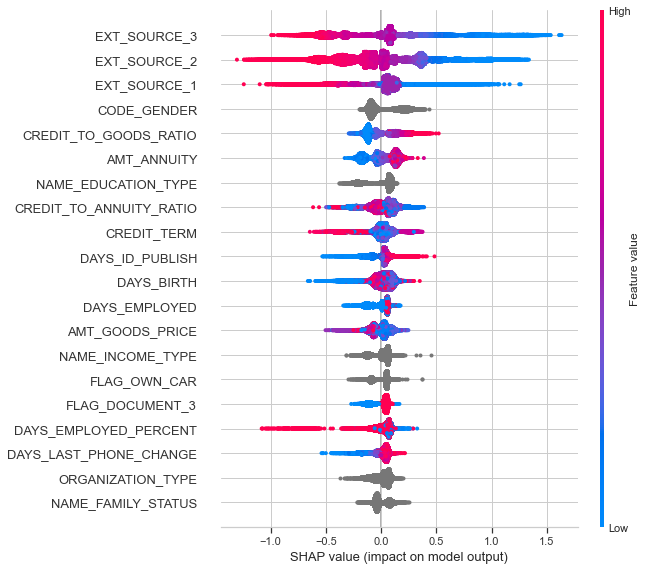

In [106]:
# Строим график

shap.summary_plot(shap_values, X_importance)

Из графика видим, чем меньше доходы клиента, тем выше шанс дефолта и наоборот. Или, например, посмотрим на строку опыта работы. Чем меньше опыт работы, тем выше шанс дефолта по кредиту.

# Выводы

## Смотрим на самые значимые фичи в разрезе таргета

In [107]:
appl_train.groupby('TARGET')['CREDIT_TO_ANNUITY_RATIO'].mean()

TARGET
0    21.686680
1    20.764818
Name: CREDIT_TO_ANNUITY_RATIO, dtype: float64

In [108]:
appl_train.groupby('TARGET')['DAYS_EMPLOYED_PERCENT'].mean()

TARGET
0   -3.003022
1   -1.976284
Name: DAYS_EMPLOYED_PERCENT, dtype: float64

In [109]:
appl_train.groupby('TARGET')['EXT_SOURCE_3'].mean()

TARGET
0    0.523767
1    0.423775
Name: EXT_SOURCE_3, dtype: float64

In [110]:
appl_train.groupby('TARGET')['EXT_SOURCE_2'].mean()

TARGET
0    0.52357
1    0.41126
Name: EXT_SOURCE_2, dtype: float64

In [111]:
appl_train.groupby('TARGET')['CREDIT_TERM'].mean()

TARGET
0    0.053610
1    0.054659
Name: CREDIT_TERM, dtype: float64

In [112]:
abs(appl_train.groupby('TARGET')['DAYS_BIRTH'].mean() / 365)

TARGET
0    0.121135
1    0.111727
Name: DAYS_BIRTH, dtype: float64

In [113]:
appl_train.groupby('TARGET')['AMT_GOODS_PRICE'].mean()

TARGET
0    542652.484651
1    488939.444955
Name: AMT_GOODS_PRICE, dtype: float64

Тут видим обратную зависимость. Большинство клиентов, кто допустил просрочку, брали кредиты на меньшие суммы нежели те, кто платил вовремя

In [114]:
(appl_train.groupby(['TARGET', 'CODE_GENDER'])['CODE_GENDER'].count(
) / appl_train['CODE_GENDER'].count()) * 100

TARGET  CODE_GENDER
0       F              61.226428
        M              30.699390
        XNA             0.001301
1       F               4.607965
        M               3.464917
Name: CODE_GENDER, dtype: float64

In [115]:
(appl_train.groupby(['TARGET', 'NAME_EDUCATION_TYPE'])['NAME_EDUCATION_TYPE'].count(
) / appl_train['NAME_EDUCATION_TYPE'].count()) * 100

TARGET  NAME_EDUCATION_TYPE          
0       Academic degree                   0.052356
        Higher education                 23.041127
        Incomplete higher                 3.058427
        Lower secondary                   1.105326
        Secondary / secondary special    64.669882
1       Academic degree                   0.000976
        Higher education                  1.303693
        Incomplete higher                 0.283567
        Lower secondary                   0.135605
        Secondary / secondary special     6.349041
Name: NAME_EDUCATION_TYPE, dtype: float64

Изначально, были выдвинуты данные гипотезы:

- 1) Большинство людей, кто допускает просрочку, работают на низкой должности. 
- 2) Если человек живет в городе с низким рейтингом (маленький город, низкий уровень жизни и т.д), риск просрочки платежа увеличивается
- 3) Клиент со средним образованием будет чаще допускать просрочку, нежели клиент с высшим образованием

После EDA анализа, а так же построения таблицы с наиболее важными для модели фичами можно подтвердить 1 и 3 гипотезы. Теперь выведем итог по самым важным фичам для неблагонадежного клиента, который может допустить просрочку выплаты по кредиту и тем самым заставить нас создать резервы под его займ, а так же благонадежного клиента, который будет платить в срок: 

TARGET = 0:

Образование - среднее / среднее специальное, средний доход на 20% больше, чем у клиентов с target=1. Средний возраст на ~ 4 года больше. Самое главное - среди не допускающие просрочку, женщин в два раза больше, чем мужчин.

TARGET = 1:

Образование - среднее / среднее специальное, средний доход на 20% меньше, чем у кслиентов с target=0. Средний возраст около 40 лет. Женщин, допустивших просрочку платежа все же больше, но если в target=1 женщин, не допускавших ее, было в 2 раза больше, то теперь лишь на 25%. Из чего делаем вывод - мужчины чаще не платят в срок.